In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
try:
    from tensorflow import keras
    from tensorflow.keras import layers, callbacks
except ImportError:
    import keras
    from keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ============================================================================
# CONFIG
# ============================================================================
TARGETS = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
TEMPORAL_FEATURES = ['hour', 'is_day', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 
                     'dow_cos', 'is_holiday', 'is_weekend', 'lockdown_code']

train_df = pd.read_csv("../data/train_features.csv")
test_df = pd.read_csv("../data/test_features_to_predict.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (40991, 213)
Test shape: (504, 208)


In [2]:

# ============================================================================
# PREPARE TRAINING DATA
# ============================================================================
print("\nPreparing training data...")
# Get all lag/roll columns
all_cols = train_df.columns.tolist()
lag_roll_cols = [c for c in all_cols if 'lag_' in c or 'roll_' in c]
feature_cols = lag_roll_cols + TEMPORAL_FEATURES

print(f"Using {len(feature_cols)} features for training")
print(f"  - Lag/Roll features: {len(lag_roll_cols)}")
print(f"  - Temporal features: {len(TEMPORAL_FEATURES)}")
print(f"Targets: {TARGETS}")

# Remove rows with NaN
train_clean = train_df[feature_cols + TARGETS].dropna()
print(f"Train samples after removing NaNs: {len(train_clean)}")

X_train_full = train_clean[feature_cols].values
Y_train_full = train_clean[TARGETS].values

# Train/Val split
split_idx = int(0.85 * len(X_train_full))
X_train = X_train_full[:split_idx]
Y_train = Y_train_full[:split_idx]
X_val = X_train_full[split_idx:]
Y_val = Y_train_full[split_idx:]

print(f"\nTrain samples: {X_train.shape[0]}")
print(f"Val samples: {X_val.shape[0]}")

# ============================================================================
# SCALE FEATURES & TARGETS
# ============================================================================
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale targets per pollutant
target_scalers = {}
Y_train_scaled = np.zeros_like(Y_train, dtype=np.float32)
Y_val_scaled = np.zeros_like(Y_val, dtype=np.float32)
for i, target in enumerate(TARGETS):
    scaler_t = StandardScaler()
    Y_train_scaled[:, i] = scaler_t.fit_transform(Y_train[:, i:i+1]).ravel()
    Y_val_scaled[:, i] = scaler_t.transform(Y_val[:, i:i+1]).ravel()
    target_scalers[target] = scaler_t

# ============================================================================
# BUILD MODEL
# ============================================================================
print("\nBuilding model...")
n_features = X_train_scaled.shape[1]
n_targets = len(TARGETS)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(n_features,)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_targets)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)
print(model.summary())

# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\nTraining model...")
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# ============================================================================
# VALIDATION METRICS
# ============================================================================
print("\nValidation MAE per pollutant:")
Y_val_pred_scaled = model.predict(X_val_scaled, verbose=0)
mae_per_pollutant = []
for i, target in enumerate(TARGETS):
    y_pred_unscaled = target_scalers[target].inverse_transform(Y_val_pred_scaled[:, i:i+1])
    mae = mean_absolute_error(Y_val[:, i], y_pred_unscaled)
    mae_per_pollutant.append(mae)
    print(f"  {target}: {mae:.4f}")
final_score_val = np.mean(mae_per_pollutant)
print(f"\nValidation Final Score (avg MAE): {final_score_val:.4f}")


Preparing training data...
Using 204 features for training
  - Lag/Roll features: 194
  - Temporal features: 10
Targets: ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
Train samples after removing NaNs: 40991

Train samples: 34842
Val samples: 6149

Scaling features...

Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        13,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,813 (61.77 KB)

 Trainable params: 15,813 (61.77 KB)

 Non-trainable params: 0 (0.00 B)

None

Training model...
Epoch 1/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5792 - mae: 0.5461 - val_loss: 0.3131 - val_mae: 0.3867
Epoch 2/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3731 - mae: 0.4302 - val_loss: 0.2685 - val_mae: 0.3508
Epoch 3/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3316 - mae: 0.4018 - val_loss: 0.2514 - val_mae: 0.3345
Epoch 4/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3079 - mae: 0.3853 - val_loss: 0.2420 - val_mae: 0.3243
Epoch 5/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2893 - mae: 0.3727 - val_loss: 0.2358 - val_mae: 0.3167
Epoch 6/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2760 - mae: 0.3631 - val_loss: 0.2263 - val_mae: 0.3084
Epoch 7/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2677 - mae: 0.3562 - val_loss: 0.2226 - val_mae: 0.3039
Epoch 8/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2614 - mae: 0.3501 - val_loss: 0.2190 - val_mae: 0.2969
Epoch 9/150
273/273 ━━━━

In [9]:
model.save('autoreg_model.keras')
print("\n✅ Best model saved")


✅ Best model saved


In [5]:
# ============================================================================
# AUTO-REGRESSIVE TEST PREDICTION
# ============================================================================
print("\n" + "="*70)
print("AUTO-REGRESSIVE TEST PREDICTION")
print("="*70)

# Step 1: Parse lag and rolling column names
print("\nStep 1: Parsing lag and rolling feature structure...")
print(f"Sample feature columns: {feature_cols[:10]}")

lag_info = {}  # {feature_name: {lag_hours: col_index}}
roll_info = {}  # {(feature_name, stat, window): col_index}

for idx, col in enumerate(feature_cols):
    if col in TEMPORAL_FEATURES:
        continue
    
    # Parse LAG features: format is "valeur_NO2_lag_6"
    if '_lag_' in col:
        parts = col.split('_lag_')
        if len(parts) == 2:
            feature_name = parts[0]
            try:
                lag_hours = int(parts[1])
                if feature_name not in lag_info:
                    lag_info[feature_name] = {}
                lag_info[feature_name][lag_hours] = idx
            except ValueError:
                print(f"Warning: Could not parse lag value from: {col}")
                continue
    
    # Parse ROLLING features: format is "valeur_NO2_roll_mean_6"
    elif '_roll_' in col:
        parts = col.split('_roll_')
        if len(parts) == 2:
            feature_name = parts[0]
            stat_and_window = parts[1].split('_')
            
            if len(stat_and_window) >= 2:
                try:
                    window = int(stat_and_window[-1])
                    stat = '_'.join(stat_and_window[:-1])
                    
                    key = (feature_name, stat, window)
                    roll_info[key] = idx
                except ValueError:
                    print(f"Warning: Could not parse rolling window from: {col}")
                    continue

print(f"\nFound lag features for: {list(lag_info.keys())[:10]}")
print(f"Found {len(roll_info)} rolling window features")

# Step 2: Initialize history buffer
print("\nStep 2: Initializing history buffer...")

max_lag = 0
if lag_info:
    max_lag = max([max(lags.keys()) for lags in lag_info.values()])

max_window = 0
if roll_info:
    max_window = max([key[2] for key in roll_info.keys()])

history_length = max(max_lag, max_window) + 1
print(f"Max lag needed: {max_lag} hours")
print(f"Max rolling window: {max_window} hours")
print(f"History buffer length: {history_length} hours")

# Initialize history
last_train = train_df.iloc[-history_length:].copy()
target_history = last_train[TARGETS].values.tolist()

feature_value_history = {}
for feature_name in lag_info.keys():
    if feature_name in last_train.columns:
        feature_value_history[feature_name] = last_train[feature_name].values.tolist()
    else:
        feature_value_history[feature_name] = [0.0] * history_length

print(f"Initialized history with last {history_length} training samples")

# Step 3: Helper function
def compute_features_from_history(target_history, feature_value_history, test_row, 
                                   feature_cols, lag_info, roll_info):
    features = np.zeros(len(feature_cols))
    
    for idx, col in enumerate(feature_cols):
        if col in TEMPORAL_FEATURES:
            if col in test_row.index:
                features[idx] = test_row[col]
            else:
                features[idx] = 0
            continue
        
        # Handle lag features
        if '_lag_' in col:
            parts = col.split('_lag_')
            if len(parts) == 2:
                feature_name = parts[0]
                try:
                    lag_hours = int(parts[1])
                    
                    if feature_name in TARGETS:
                        target_idx = TARGETS.index(feature_name)
                        if lag_hours <= len(target_history):
                            features[idx] = target_history[-lag_hours][target_idx]
                    elif feature_name in feature_value_history:
                        if lag_hours <= len(feature_value_history[feature_name]):
                            features[idx] = feature_value_history[feature_name][-lag_hours]
                except (ValueError, IndexError):
                    features[idx] = 0
        
        # Handle rolling features
        elif '_roll_' in col:
            parts = col.split('_roll_')
            if len(parts) == 2:
                feature_name = parts[0]
                stat_and_window = parts[1].split('_')
                
                if len(stat_and_window) >= 2:
                    try:
                        window = int(stat_and_window[-1])
                        stat = '_'.join(stat_and_window[:-1])
                        
                        values = []
                        if feature_name in TARGETS:
                            target_idx = TARGETS.index(feature_name)
                            values = [row[target_idx] for row in target_history[-window:]]
                        elif feature_name in feature_value_history:
                            values = feature_value_history[feature_name][-window:]
                        
                        if len(values) > 0:
                            if stat == 'mean':
                                features[idx] = np.mean(values)
                            elif stat == 'std':
                                features[idx] = np.std(values)
                            elif stat == 'min':
                                features[idx] = np.min(values)
                            elif stat == 'max':
                                features[idx] = np.max(values)
                    except (ValueError, IndexError):
                        features[idx] = 0
    
    return features

# Step 4: Iterative prediction
print("\nStep 4: Predicting test samples iteratively...")
test_predictions = []

for idx in range(len(test_df)):
    if idx % 500 == 0:
        print(f"  Predicting sample {idx}/{len(test_df)}...")
    
    test_row = test_df.iloc[idx]
    
    features = compute_features_from_history(
        target_history, feature_value_history, test_row, 
        feature_cols, lag_info, roll_info
    )
    
    features_scaled = scaler.transform(features.reshape(1, -1))
    pred_scaled = model.predict(features_scaled, verbose=0)
    
    pred_unscaled = np.zeros(n_targets)
    for i, target in enumerate(TARGETS):
        pred_unscaled[i] = target_scalers[target].inverse_transform(
            pred_scaled[:, i:i+1]
        ).ravel()[0]
    
    test_predictions.append(pred_unscaled)
    
    # Update history
    target_history.append(pred_unscaled.tolist())
    
    for feature_name in feature_value_history.keys():
        if feature_name not in TARGETS:
            feature_value_history[feature_name].append(
                feature_value_history[feature_name][-1]
            )
    
    if len(target_history) > history_length:
        target_history.pop(0)
    for feature_name in feature_value_history.keys():
        if len(feature_value_history[feature_name]) > history_length:
            feature_value_history[feature_name].pop(0)

test_predictions = np.array(test_predictions)
print(f"✅ Test predictions shape: {test_predictions.shape}")



AUTO-REGRESSIVE TEST PREDICTION

Step 1: Parsing lag and rolling feature structure...
Sample feature columns: ['valeur_NO2_lag_6', 'valeur_NO2_lag_12', 'valeur_NO2_lag_24', 'valeur_NO2_roll_mean_6', 'valeur_NO2_roll_std_6', 'valeur_NO2_roll_mean_24', 'valeur_NO2_roll_std_24', 'valeur_CO_lag_6', 'valeur_CO_lag_12', 'valeur_CO_lag_24']

Found lag features for: ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'pressure_msl']
Found 110 rolling window features

Step 2: Initializing history buffer...
Max lag needed: 24 hours
Max rolling window: 24 hours
History buffer length: 25 hours
Initialized history with last 25 training samples

Step 4: Predicting test samples iteratively...
  Predicting sample 0/504...
  Predicting sample 500/504...
✅ Test predictions shape: (504, 5)


In [6]:
# ============================================================================
# CREATE SUBMISSION
# ============================================================================
print("\nCreating autoregressive submission file...")
submission_ar = pd.DataFrame()
submission_ar['id'] = test_df['id'].values
for i, target in enumerate(TARGETS):
    submission_ar[target] = test_predictions[:, i]

submission_ar.to_csv('ffnn_autoregressive_submission.csv', index=False)
print("✅ Autoregressive submission saved to ffnn_autoregressive_submission.csv")
print(f"\nSubmission preview:\n{submission_ar.head()}")
print(f"\nSubmission shape: {submission_ar.shape}")



Creating autoregressive submission file...
✅ Autoregressive submission saved to ffnn_autoregressive_submission.csv

Submission preview:
              id  valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
0  2024-09-03 23   20.437149   0.192183  53.777893     7.219193     5.087048
1  2024-09-04 00   19.769053   0.188569  51.815929     7.273933     4.965388
2  2024-09-04 01   19.588804   0.185683  51.788334     6.832823     4.616332
3  2024-09-04 02   19.649734   0.184377  51.769169     6.664112     4.456013
4  2024-09-04 03   19.447744   0.183485  52.030190     6.519917     4.342272

Submission shape: (504, 6)


In [7]:
# ============================================================================
# SANITY CHECK
# ============================================================================
print("\n" + "="*70)
print("SANITY CHECK - Prediction Statistics")
print("="*70)
for i, target in enumerate(TARGETS):
    print(f"\n{target}:")
    print(f"  Train mean: {train_df[target].mean():.2f}")
    print(f"  Test predictions mean: {test_predictions[:, i].mean():.2f}")
    print(f"  Test predictions range: [{test_predictions[:, i].min():.2f}, {test_predictions[:, i].max():.2f}]")


SANITY CHECK - Prediction Statistics

valeur_NO2:
  Train mean: 22.34
  Test predictions mean: 20.35
  Test predictions range: [18.93, 21.38]

valeur_CO:
  Train mean: 0.21
  Test predictions mean: 0.20
  Test predictions range: [0.18, 0.20]

valeur_O3:
  Train mean: 50.65
  Test predictions mean: 55.80
  Test predictions range: [51.77, 58.18]

valeur_PM10:
  Train mean: 18.43
  Test predictions mean: 7.34
  Test predictions range: [6.33, 8.33]

valeur_PM25:
  Train mean: 11.00
  Test predictions mean: 5.33
  Test predictions range: [4.34, 6.07]


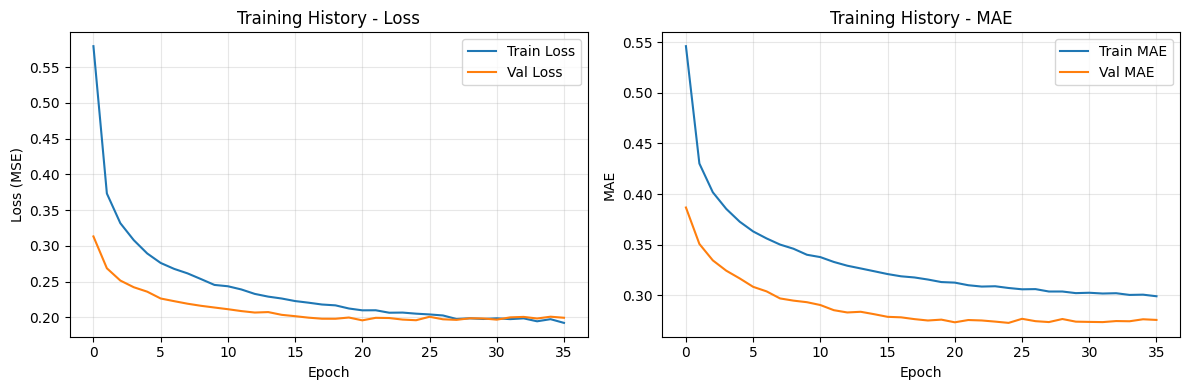

✅ Training history plot saved


In [8]:
# ============================================================================
# PLOT TRAINING HISTORY
# ============================================================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training History - Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training History - MAE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoregressive_training_history.png', dpi=100, bbox_inches='tight')
plt.show()
print("✅ Training history plot saved")